Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO

Библиотеки: [Python, Tensorflow]

In [2]:
import tensorflow as tf

gpu_device = tf.config.experimental.list_physical_devices('GPU')
if gpu_device:
    tf.config.experimental.set_memory_growth(gpu_device[0], True)

In [8]:
# !pip install pycocotools

In [7]:
# !pip install albumentations

In [6]:
# !pip install opencv-python

In [3]:
import os
import random
import numpy as np

import cv2
import albumentations as A

from pycocotools.coco import COCO
from matplotlib import pyplot as plt

from tensorflow.keras import layers

### Загрузка данных.

Реализуем кастомный датасет, с возможностью добавления функции для аугментации данных.

In [4]:
class COCODataset:
    
    def __init__(self, root_path, classes, out_shape, train=False, shuffle=False, transform=None):
        self.root_path = root_path
        self.out_shape = out_shape
        self.shuffle = shuffle
        self.train = train
        if train:
            sublist = 'train2017'
        else:
            sublist = 'val2017'
        self.coco = COCO(os.path.join(root_path, 'annotations', f'instances_{sublist}.json'))
        self.cat_ids = self.coco.getCatIds(catNms=classes)
        self.indices = self.coco.getImgIds(catIds=self.cat_ids)
        
        self.transform = transform
        
    def _read_img_mask(self, idx):
        img_data = self.coco.loadImgs(self.indices[idx])[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])
        
        img = cv2.imread(os.path.join(self.root_path, img_fname))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask = np.zeros((img.shape[0], img.shape[1]), dtype='float')
        for i in range(len(anns)):
            mask += self.coco.annToMask(anns[i])
        mask = (mask > 0).astype('float')
        return img, mask
    
    def _crop(self, img):
        shape = img.shape[:2]
        out_size = np.min(shape)
        h_diff = shape[0] - out_size
        w_diff = shape[1] - out_size
        
        if self.train: # random crop
            shift_factor = random.random()
            ho = int(h_diff * shift_factor)
            wo = int(w_diff * shift_factor)
        else: # central crop
            ho = h_diff // 2
            wo = w_diff // 2
        
        return img[ho:ho + out_size, wo:wo + out_size, ...]
    
    def __getitem__(self, idx):
        img, mask = self._read_img_mask(idx)
        img = img / 255
        if len(img.shape) == 2:
            img = np.repeat(img[..., np.newaxis], 3, axis=2)
        
        combined = np.append(img, mask[..., np.newaxis], axis=2)
        combined = self._crop(combined)
        combined = cv2.resize(combined, self.out_shape)
        
        if self.transform:
            combined = self.transform(image=combined)['image']

        return combined[..., :3], combined[..., 3:]
    
    def __len__(self):
        return len(self.indices)
    
    def flow(self):
        _indices = np.arange(self.__len__())
        if self.shuffle:
            _indices = np.random.permutation(_indices)
        for idx in _indices:
            yield self.__getitem__(idx)

Аугментация данных.

In [5]:
transform = A.Compose([
    A.HorizontalFlip(),
    A.Rotate(limit=90, border_mode=0, value=0),
    A.OpticalDistortion(), 
    A.GridDistortion(distort_limit=(-0.15, 0.15), border_mode=0, value=0), 
    A.Transpose()
])

In [6]:
DATA_PATH = './data'
OUTPUT_SHAPE = (256, 256)

train_dataset = COCODataset(
    root_path=DATA_PATH, 
    classes=['person'], 
    out_shape=OUTPUT_SHAPE, 
    train=True, 
    shuffle=True, 
    transform=transform)

val_dataset = COCODataset(
    root_path=DATA_PATH, 
    classes=['person'], 
    out_shape=OUTPUT_SHAPE)

loading annotations into memory...
Done (t=17.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [7]:
def plot_img_mask(img, mask, plot):
    seg_map_clr = plt.get_cmap('viridis')(mask[..., 0])[..., :3]
    plot.imshow(img * 0.5 + seg_map_clr * 0.5)

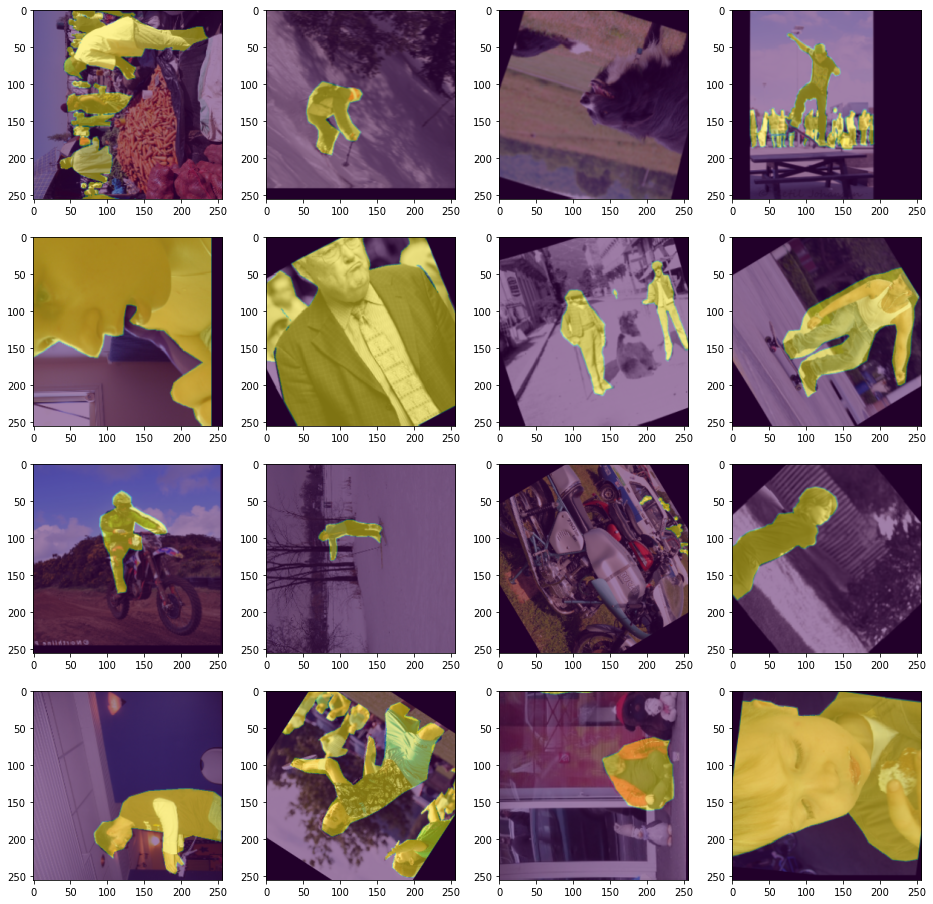

In [8]:
n_samples = 16

fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for i, (img, mask) in enumerate(train_dataset):
    if i >= n_samples:
        break
    pos = ax[i//4, i%4]
    plot_img_mask(img, mask, pos)

Реализуем сеть архитектуры LinkNet. В отличие от U-Net, тензоры складываются, а не конкатенируются. Тем самым обучение и инференс сети происходит чуть быстрее, чем U-Net.

In [9]:
class ConvBlock(tf.keras.Model):
    
    def __init__(self, n_filters, batchnorm=True, **kwargs):
        super().__init__()
        self.batchnorm = batchnorm
        
        self.conv = layers.Conv2D(n_filters, kernel_size=(3, 3), padding='same', **kwargs)
        self.norm = layers.BatchNormalization()
        self.activation = layers.LeakyReLU()
    
    def call(self, x):
        out = self.conv(x)
        out = self.activation(out)
        
        if self.batchnorm:
            out = self.norm(out)
            
        return out


class EncoderBlock(tf.keras.Model):
    
    def __init__(self, n_filters, batchnorm=True, **kwargs):
        super().__init__()
        self.batchnorm = batchnorm
        
        self.conv = layers.Conv2D(n_filters, kernel_size=(4, 4), strides=(2, 2), padding='same', **kwargs)
        self.norm = layers.BatchNormalization()
        self.activation = layers.LeakyReLU()
    
    def call(self, x):
        out = self.conv(x)
        out = self.activation(out)
        
        if self.batchnorm:
            out = self.norm(out)
            
        return out
    
    
class DecoderBlock(tf.keras.Model):
    
    def __init__(self, n_filters, batchnorm=True, **kwargs):
        super().__init__()
        self.batchnorm = batchnorm
        
        self.conv = layers.Conv2DTranspose(n_filters, kernel_size=(4, 4), strides=(2, 2), padding='same', **kwargs)
        self.norm = layers.BatchNormalization()
        self.activation = layers.LeakyReLU()
    
    def call(self, x, skip_in):
        out = self.conv(x)
        out = out + skip_in
        out = self.activation(out)
        
        if self.batchnorm:
            out = self.norm(out)
            
        return out

In [10]:
class LinkNet(tf.keras.Model):
    
    def __init__(self, **kwargs):
        super().__init__()
        
        # (256, 256, 3) --> (256, 256, 32)
        self.conv_inp = ConvBlock(32, batchnorm=True)
        
        # (256, 256, 32) --> (128, 128, 64)
        self.e1 = EncoderBlock(64, batchnorm=True, **kwargs)
        
        # (128, 128, 64) --> (64, 64, 128)
        self.e2 = EncoderBlock(128, batchnorm=True, **kwargs)
        
        # (64, 64, 128) --> (32, 32, 256)
        self.e3 = EncoderBlock(256, batchnorm=True)
        
        # (32, 32, 256) --> (16, 16, 512)
        self.e4 = EncoderBlock(512, batchnorm=True)
        
        # (16, 16, 256) --> (8, 8, 512)
        self.e5 = EncoderBlock(512, batchnorm=True)
        
        # bottleneck (8, 8, 512) --> (4, 4, 512)
        self.b = layers.Conv2D(512, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu')
        
        # (4, 4, 512) --> (8, 8, 512)
        self.d1 = DecoderBlock(512, batchnorm=True)
        
        # (8, 8, 512) --> (16, 16, 512)
        self.d2 = DecoderBlock(512, batchnorm=True)
        
        # (16, 16, 512) --> (32, 32, 256)
        self.d3 = DecoderBlock(256, batchnorm=True)
        
        # (32, 32, 256) --> (64, 64, 128)
        self.d4 = DecoderBlock(128, batchnorm=True, **kwargs)
        
        # (64, 64, 128) --> (128, 128, 64)
        self.d5 = DecoderBlock(64, batchnorm=True, **kwargs)
        
        # (128, 128, 64) --> (256, 256, 32)
        self.d6 = DecoderBlock(32, batchnorm=True, **kwargs)
        self.conv_out = ConvBlock(32, batchnorm=True)
        
        # (256, 256, 32) --> (256, 256, 1)
        self.o = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid')
        
    def call(self, inputs):
        
        conv_inp = self.conv_inp(inputs)
        
        e1 = self.e1(inputs)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        
        b = self.b(e5)
        
        d1 = self.d1(b, e5)
        d2 = self.d2(d1, e4)
        d3 = self.d3(d2, e3)
        d4 = self.d4(d3, e2)
        d5 = self.d5(d4, e1)
        
        d6 = self.d6(d5, conv_inp)
        
        conv_out = self.conv_out(d6)
        
        outputs = self.o(conv_out)
        
        return outputs

In [11]:
WEIGHT_DECAY = 1e-5
BIAS_DECAY = 1e-4

# wd = tf.keras.regularizers.l2(WEIGHT_DECAY)
# bd = tf.keras.regularizers.l2(BIAS_DECAY)

wd = None
bd = None

In [14]:
model = LinkNet(kernel_regularizer=wd, bias_regularizer=bd)

model.build((None, 256, 256, 3))

model.summary()

Model: "link_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block_2 (ConvBlock)     multiple                  1024      
_________________________________________________________________
encoder_block_5 (EncoderBloc multiple                  3392      
_________________________________________________________________
encoder_block_6 (EncoderBloc multiple                  131712    
_________________________________________________________________
encoder_block_7 (EncoderBloc multiple                  525568    
_________________________________________________________________
encoder_block_8 (EncoderBloc multiple                  2099712   
_________________________________________________________________
encoder_block_9 (EncoderBloc multiple                  4196864   
_________________________________________________________________
conv2d_15 (Conv2D)           multiple                  4

In [25]:
def dice_loss(logits, targets):
    smooth = 1.
    num = targets.shape[2]
    m1 = tf.reshape(logits, shape=(num, -1))
    m2 = tf.reshape(targets, shape=(num, -1))
    
    intersection = m1 * m2
    
    score = (2. * tf.math.reduce_sum(intersection, 1) + smooth) / \
    (tf.math.reduce_sum(m1, 1) + tf.math.reduce_sum(m2, 1) + smooth)
    
    score = 1. - (tf.math.reduce_sum(score) / num)
    
    return score

In [15]:
loss = tf.keras.losses.BinaryCrossentropy()
# loss = dice_loss
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=loss)

In [16]:
model.summary()

Model: "link_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block_2 (ConvBlock)     multiple                  1024      
_________________________________________________________________
encoder_block_5 (EncoderBloc multiple                  3392      
_________________________________________________________________
encoder_block_6 (EncoderBloc multiple                  131712    
_________________________________________________________________
encoder_block_7 (EncoderBloc multiple                  525568    
_________________________________________________________________
encoder_block_8 (EncoderBloc multiple                  2099712   
_________________________________________________________________
encoder_block_9 (EncoderBloc multiple                  4196864   
_________________________________________________________________
conv2d_15 (Conv2D)           multiple                  4

In [17]:
BATCH_SIZE = 8
NUM_EPOCHS = 5

train_ds = tf.data.Dataset.from_generator(train_dataset.flow, 
                                          output_types=(tf.float32, tf.float16), 
                                          output_shapes=((256, 256, 3), (256, 256, 1))
                                         )
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

val_ds = tf.data.Dataset.from_generator(val_dataset.flow, 
                                          output_types=(tf.float32, tf.float16), 
                                          output_shapes=((256, 256, 3), (256, 256, 1))
                                         )
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler


def scheduler(epoch):
    lr = 1e-3
    return lr * np.exp(-0.7 * epoch)


lr_scheduler = LearningRateScheduler(
                                    schedule=scheduler, 
                                    verbose=1
)

In [20]:
history = model.fit(train_ds, 
                    steps_per_epoch=len(train_dataset)//BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    callbacks=[lr_scheduler])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/5
8014/8014 [==============================] - 3876s 484ms/step - loss: 0.3724 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0004965853037914096.
Epoch 2/5
8014/8014 [==============================] - 3869s 483ms/step - loss: 0.3290 - lr: 4.9659e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002465969639416065.
Epoch 3/5
8014/8014 [==============================] - 3866s 482ms/step - loss: 0.3092 - lr: 2.4660e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00012245642825298194.
Epoch 4/5
8014/8014 [==============================] - 3868s 483ms/step - loss: 0.2964 - lr: 1.2246e-04

Epoch 00005: LearningRateScheduler reducing learning rate to 6.0810062625217975e-05.
Epoch 5/5
8014/8014 [==============================] - 3872s 483ms/step - loss: 0.2894 - lr: 6.0810e-05


In [21]:
model.evaluate(val_ds)

336/336 [==============================] - 96s 285ms/step - loss: 0.3046


0.30462881922721863

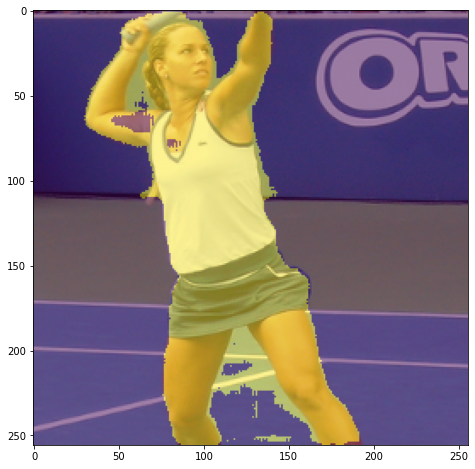

In [58]:
idx = np.random.randint(len(val_dataset))
img, _ = val_dataset[idx]

logits = model(img[None]).numpy()[0]
mask = (logits > 0.5).astype('float')

plt.figure(figsize=(8, 8))
plot_img_mask(img, mask, plt)